To detect and quantify localized hotspots of ancient DNA (aDNA) damage—specifically 5' cytosine-to-thymine (C→T) misincorporations—across the genome of sample J-44, using a robust, reference-matched aDNA workflow.

In [36]:
import os
import shutil
import subprocess
import pysam
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt

In [6]:
bam_file_path = "/Users/eviecolbeck/Documents/aDNA_project/J-44.merged.hg19.sort.rmdup.bam"
fasta_file_path = "/Users/eviecolbeck/Documents/aDNA_project/hs37d5.fa" #hg37 doesnt have chr prefixes
output_dir = "damage_output_full"
window_size = 10000
Z_DAMAGE_THRESHOLD = 2.58

os.makedirs(output_dir, exist_ok=True)

# Canonical chromosome list
target_chroms = [str(i) for i in range(1, 23)] + ["X", "Y", "MT"]

detect correct chromosome naming

In [7]:
with pysam.AlignmentFile(bam_file_path, "rb") as bam:
    header_chroms = set(bam.references)

use_chr_prefix = False
if "chr1" in header_chroms:
    use_chr_prefix = True

chrom_map = {}
for c in target_chroms:
    cand = f"chr{c}" if use_chr_prefix else c
    if cand in header_chroms:
        chrom_map[c] = cand

print("Chromosomes detected in BAM:", chrom_map)

Chromosomes detected in BAM: {'1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': '10', '11': '11', '12': '12', '13': '13', '14': '14', '15': '15', '16': '16', '17': '17', '18': '18', '19': '19', '20': '20', '21': '21', '22': '22', 'X': 'X', 'Y': 'Y', 'MT': 'MT'}


In [8]:
# per chromosome subsetting + indexing for handling speed 
def subset_chromosome(bam_path, chrom, out_bam):
    """Extract chromosome-specific BAM."""
    with pysam.AlignmentFile(bam_path, "rb") as bam_in:
        with pysam.AlignmentFile(out_bam, "wb", template=bam_in) as bam_out:
            for read in bam_in.fetch(chrom):
                bam_out.write(read)
    pysam.index(out_bam)


def run_mapdamage(bam, fasta, outdir):
    """Run mapDamage."""
    if os.path.exists(outdir):
        shutil.rmtree(outdir)
    os.makedirs(outdir)

    subprocess.run([
        "mapDamage",
        "-i", bam,
        "-r", fasta,
        "--merge-reference-sequences",
        "--no-stats",
        "-d", outdir
    ], check=True)

# use Z ≥ 2.58 (p < 0.01) to indentify statistically significant windows of damage
def summarize_damage(bam_path, chrom, window_size):
    """Compute C→T hotspot windows."""
    with pysam.AlignmentFile(bam_path, "rb") as bam:
        if chrom not in bam.references:
            return pd.DataFrame()

        chrom_len = dict((sq["SN"], sq["LN"]) for sq in bam.header["SQ"])[chrom]

        starts = []
        ct_counts = []

        for read in bam.fetch(chrom):
            if read.is_unmapped or read.query_sequence is None:
                continue
            starts.append(read.reference_start)

            # Approximate 5' C->T (count T in first 4 bases)
            seq = read.query_sequence
            ct_counts.append(sum(base == "T" for base in seq[:4]))

        if len(starts) == 0:
            return pd.DataFrame()

        # Windows
        bins = np.arange(0, chrom_len + window_size, window_size)
        num_windows = len(bins) - 1

        ct_window_sums = np.zeros(num_windows)
        ct_window_counts = np.zeros(num_windows)

        for start, val in zip(starts, ct_counts):
            win = start // window_size
            if win < num_windows:
                ct_window_sums[win] += val
                ct_window_counts[win] += 1

        ct_window_avg = np.where(ct_window_counts > 0,
                                 ct_window_sums / ct_window_counts,
                                 np.nan)

        # Z-scores
        if not np.isnan(ct_window_avg).all() and np.nanstd(ct_window_avg) > 0:
            ct_z = (ct_window_avg - np.nanmean(ct_window_avg)) / np.nanstd(ct_window_avg)
        else:
            ct_z = np.full_like(ct_window_avg, np.nan)

        # Collect hotspots
        hotspots = []
        for i in range(num_windows):
            if not np.isnan(ct_z[i]) and ct_z[i] >= Z_DAMAGE_THRESHOLD:
                hotspots.append({
                    "Chromosome": chrom,
                    "Start": int(bins[i]),
                    "End": int(bins[i+1]),
                    "CT_Avg": float(ct_window_avg[i]),
                    "CT_Z": float(ct_z[i])
                })

        df = pd.DataFrame(hotspots)
        return df

In [9]:
all_hotspots = []

for short_name, chrom in chrom_map.items():
    print(f"\n=== Processing chromosome {chrom} ===")

    chrom_bam = os.path.join(output_dir, f"{chrom}.bam")
    mapdamage_dir = os.path.join(output_dir, f"mapdamage_{chrom}")
    out_csv = os.path.join(output_dir, f"{chrom}_damage_summary.csv")

    print(" → Subsetting…")
    subset_chromosome(bam_file_path, chrom, chrom_bam)

    print(" → Running mapDamage…")
    run_mapdamage(chrom_bam, fasta_file_path, mapdamage_dir)

    print(" → Summarizing hotspots…")
    df = summarize_damage(chrom_bam, chrom, window_size)
    df.to_csv(out_csv, index=False)

    print(f" → Saved: {out_csv}")
    all_hotspots.append(df)

# Combine all chromosomes into one genome-wide file
combined = pd.concat(all_hotspots, ignore_index=True)
combined.to_csv(os.path.join(output_dir, "GENOME_DAMAGE_SUMMARY.csv"), index=False)

print("Combined output written to GENOME_DAMAGE_SUMMARY.csv")


=== Processing chromosome 1 ===
 → Subsetting…
 → Running mapDamage…
Warning, damage_output_full/mapdamage_1 already exists


Started with the command: /opt/homebrew/Caskroom/miniconda/base/envs/bioinfo/bin/mapDamage -i damage_output_full/1.bam -r /Users/eviecolbeck/Documents/aDNA_project/hs37d5.fa --merge-reference-sequences --no-stats -d damage_output_full/mapdamage_1
Sequence dictionaries in FASTA/BAM files differ:
    - GL000217.1 = 172149 bp
    - GL000233.1 = 45941 bp
    - GL000197.1 = 37175 bp
    - GL000247.1 = 36422 bp
    - GL000234.1 = 40531 bp
    - GL000220.1 = 161802 bp
    - GL000248.1 = 39786 bp
    - GL000237.1 = 45867 bp
    - GL000191.1 = 106433 bp
    - GL000207.1 = 4262 bp
    - GL000225.1 = 211173 bp
    - GL000245.1 = 36651 bp
    - GL000241.1 = 42152 bp
    - GL000224.1 = 179693 bp
    - GL000219.1 = 179198 bp
    - GL000242.1 = 43523 bp
    - GL000200.1 = 187035 bp
    - GL000201.1 = 36148 bp
    - GL000195.1 = 182896 bp
    - GL000239.1 = 33824 bp
    - GL000209.1 = 159169 bp
    - hs37d5 = 35477943 bp
    - GL000244.1 = 39929 bp
    - GL000205.1 = 174588 bp
    - GL000194.1 = 19146

	Reading from 'damage_output_full/1.bam'
	Writing results to 'damage_output_full/mapdamage_1/'
pdf damage_output_full/mapdamage_1/Fragmisincorporation_plot.pdf generated
additional damage_output_full/mapdamage_1/Length_plot.pdf generated
 → Summarizing hotspots…


Successful run
/var/folders/84/xd2z0gq55jl18gs1vfptxq3w0000gn/T/ipykernel_13643/818524161.py:64: RuntimeWarning: invalid value encountered in divide
  ct_window_sums / ct_window_counts,


 → Saved: damage_output_full/1_damage_summary.csv

=== Processing chromosome 2 ===
 → Subsetting…
 → Running mapDamage…
Warning, damage_output_full/mapdamage_2 already exists


Started with the command: /opt/homebrew/Caskroom/miniconda/base/envs/bioinfo/bin/mapDamage -i damage_output_full/2.bam -r /Users/eviecolbeck/Documents/aDNA_project/hs37d5.fa --merge-reference-sequences --no-stats -d damage_output_full/mapdamage_2
Sequence dictionaries in FASTA/BAM files differ:
    - GL000238.1 = 39939 bp
    - GL000201.1 = 36148 bp
    - GL000223.1 = 180455 bp
    - GL000233.1 = 45941 bp
    - GL000205.1 = 174588 bp
    - GL000210.1 = 27682 bp
    - GL000218.1 = 161147 bp
    - GL000244.1 = 39929 bp
    - GL000209.1 = 159169 bp
    - GL000216.1 = 172294 bp
    - GL000228.1 = 129120 bp
    - GL000225.1 = 211173 bp
    - GL000248.1 = 39786 bp
    - GL000194.1 = 191469 bp
    - GL000191.1 = 106433 bp
    - GL000208.1 = 92689 bp
    - GL000214.1 = 137718 bp
    - GL000212.1 = 186858 bp
    - GL000236.1 = 41934 bp
    - GL000232.1 = 40652 bp
    - GL000229.1 = 19913 bp
    - GL000192.1 = 547496 bp
    - GL000215.1 = 172545 bp
    - GL000206.1 = 41001 bp
    - GL000200.1 = 

	Reading from 'damage_output_full/2.bam'
	Writing results to 'damage_output_full/mapdamage_2/'
pdf damage_output_full/mapdamage_2/Fragmisincorporation_plot.pdf generated
additional damage_output_full/mapdamage_2/Length_plot.pdf generated
 → Summarizing hotspots…


Successful run
/var/folders/84/xd2z0gq55jl18gs1vfptxq3w0000gn/T/ipykernel_13643/818524161.py:64: RuntimeWarning: invalid value encountered in divide
  ct_window_sums / ct_window_counts,


 → Saved: damage_output_full/2_damage_summary.csv

=== Processing chromosome 3 ===
 → Subsetting…
 → Running mapDamage…
Warning, damage_output_full/mapdamage_3 already exists


Started with the command: /opt/homebrew/Caskroom/miniconda/base/envs/bioinfo/bin/mapDamage -i damage_output_full/3.bam -r /Users/eviecolbeck/Documents/aDNA_project/hs37d5.fa --merge-reference-sequences --no-stats -d damage_output_full/mapdamage_3
Sequence dictionaries in FASTA/BAM files differ:
    - GL000222.1 = 186861 bp
    - GL000249.1 = 38502 bp
    - GL000215.1 = 172545 bp
    - GL000229.1 = 19913 bp
    - GL000208.1 = 92689 bp
    - GL000200.1 = 187035 bp
    - GL000246.1 = 38154 bp
    - GL000248.1 = 39786 bp
    - GL000201.1 = 36148 bp
    - GL000220.1 = 161802 bp
    - GL000226.1 = 15008 bp
    - GL000221.1 = 155397 bp
    - GL000211.1 = 166566 bp
    - GL000218.1 = 161147 bp
    - GL000198.1 = 90085 bp
    - GL000204.1 = 81310 bp
    - GL000197.1 = 37175 bp
    - GL000242.1 = 43523 bp
    - GL000207.1 = 4262 bp
    - GL000219.1 = 179198 bp
    - GL000227.1 = 128374 bp
    - GL000191.1 = 106433 bp
    - GL000209.1 = 159169 bp
    - NC_007605 = 171823 bp
    - GL000205.1 = 174

	Reading from 'damage_output_full/3.bam'
	Writing results to 'damage_output_full/mapdamage_3/'
pdf damage_output_full/mapdamage_3/Fragmisincorporation_plot.pdf generated
additional damage_output_full/mapdamage_3/Length_plot.pdf generated
 → Summarizing hotspots…


Successful run
/var/folders/84/xd2z0gq55jl18gs1vfptxq3w0000gn/T/ipykernel_13643/818524161.py:64: RuntimeWarning: invalid value encountered in divide
  ct_window_sums / ct_window_counts,


 → Saved: damage_output_full/3_damage_summary.csv

=== Processing chromosome 4 ===
 → Subsetting…
 → Running mapDamage…
Warning, damage_output_full/mapdamage_4 already exists


Started with the command: /opt/homebrew/Caskroom/miniconda/base/envs/bioinfo/bin/mapDamage -i damage_output_full/4.bam -r /Users/eviecolbeck/Documents/aDNA_project/hs37d5.fa --merge-reference-sequences --no-stats -d damage_output_full/mapdamage_4
Sequence dictionaries in FASTA/BAM files differ:
    - GL000198.1 = 90085 bp
    - GL000208.1 = 92689 bp
    - GL000214.1 = 137718 bp
    - GL000244.1 = 39929 bp
    - GL000230.1 = 43691 bp
    - GL000200.1 = 187035 bp
    - GL000247.1 = 36422 bp
    - GL000206.1 = 41001 bp
    - GL000225.1 = 211173 bp
    - GL000197.1 = 37175 bp
    - GL000240.1 = 41933 bp
    - GL000191.1 = 106433 bp
    - GL000246.1 = 38154 bp
    - GL000228.1 = 129120 bp
    - GL000229.1 = 19913 bp
    - GL000221.1 = 155397 bp
    - GL000199.1 = 169874 bp
    - GL000194.1 = 191469 bp
    - GL000192.1 = 547496 bp
    - GL000236.1 = 41934 bp
    - GL000207.1 = 4262 bp
    - GL000238.1 = 39939 bp
    - GL000233.1 = 45941 bp
    - GL000249.1 = 38502 bp
    - hs37d5 = 35477943 

	Reading from 'damage_output_full/4.bam'
	Writing results to 'damage_output_full/mapdamage_4/'
pdf damage_output_full/mapdamage_4/Fragmisincorporation_plot.pdf generated
additional damage_output_full/mapdamage_4/Length_plot.pdf generated
 → Summarizing hotspots…


Successful run
/var/folders/84/xd2z0gq55jl18gs1vfptxq3w0000gn/T/ipykernel_13643/818524161.py:64: RuntimeWarning: invalid value encountered in divide
  ct_window_sums / ct_window_counts,


 → Saved: damage_output_full/4_damage_summary.csv

=== Processing chromosome 5 ===
 → Subsetting…
 → Running mapDamage…
Warning, damage_output_full/mapdamage_5 already exists


Started with the command: /opt/homebrew/Caskroom/miniconda/base/envs/bioinfo/bin/mapDamage -i damage_output_full/5.bam -r /Users/eviecolbeck/Documents/aDNA_project/hs37d5.fa --merge-reference-sequences --no-stats -d damage_output_full/mapdamage_5
Sequence dictionaries in FASTA/BAM files differ:
    - GL000238.1 = 39939 bp
    - GL000233.1 = 45941 bp
    - GL000234.1 = 40531 bp
    - GL000215.1 = 172545 bp
    - GL000244.1 = 39929 bp
    - GL000235.1 = 34474 bp
    - GL000199.1 = 169874 bp
    - GL000192.1 = 547496 bp
    - GL000249.1 = 38502 bp
    - GL000207.1 = 4262 bp
    - GL000241.1 = 42152 bp
    - GL000224.1 = 179693 bp
    - GL000212.1 = 186858 bp
    - GL000195.1 = 182896 bp
    - GL000245.1 = 36651 bp
    - GL000210.1 = 27682 bp
    - GL000242.1 = 43523 bp
    - GL000196.1 = 38914 bp
    - GL000248.1 = 39786 bp
    - GL000243.1 = 43341 bp
    - GL000223.1 = 180455 bp
    - GL000222.1 = 186861 bp
    - GL000231.1 = 27386 bp
    - GL000202.1 = 40103 bp
    - GL000237.1 = 45867 

	Reading from 'damage_output_full/5.bam'
	Writing results to 'damage_output_full/mapdamage_5/'
pdf damage_output_full/mapdamage_5/Fragmisincorporation_plot.pdf generated
additional damage_output_full/mapdamage_5/Length_plot.pdf generated
 → Summarizing hotspots…


Successful run
/var/folders/84/xd2z0gq55jl18gs1vfptxq3w0000gn/T/ipykernel_13643/818524161.py:64: RuntimeWarning: invalid value encountered in divide
  ct_window_sums / ct_window_counts,


 → Saved: damage_output_full/5_damage_summary.csv

=== Processing chromosome 6 ===
 → Subsetting…
 → Running mapDamage…
Warning, damage_output_full/mapdamage_6 already exists


Started with the command: /opt/homebrew/Caskroom/miniconda/base/envs/bioinfo/bin/mapDamage -i damage_output_full/6.bam -r /Users/eviecolbeck/Documents/aDNA_project/hs37d5.fa --merge-reference-sequences --no-stats -d damage_output_full/mapdamage_6
Sequence dictionaries in FASTA/BAM files differ:
    - GL000212.1 = 186858 bp
    - GL000233.1 = 45941 bp
    - GL000227.1 = 128374 bp
    - GL000249.1 = 38502 bp
    - GL000216.1 = 172294 bp
    - GL000226.1 = 15008 bp
    - GL000234.1 = 40531 bp
    - GL000230.1 = 43691 bp
    - GL000204.1 = 81310 bp
    - GL000225.1 = 211173 bp
    - GL000214.1 = 137718 bp
    - GL000197.1 = 37175 bp
    - GL000238.1 = 39939 bp
    - GL000223.1 = 180455 bp
    - GL000241.1 = 42152 bp
    - GL000208.1 = 92689 bp
    - GL000200.1 = 187035 bp
    - GL000206.1 = 41001 bp
    - GL000246.1 = 38154 bp
    - hs37d5 = 35477943 bp
    - GL000220.1 = 161802 bp
    - GL000195.1 = 182896 bp
    - GL000232.1 = 40652 bp
    - GL000211.1 = 166566 bp
    - GL000199.1 = 1698

	Reading from 'damage_output_full/6.bam'
	Writing results to 'damage_output_full/mapdamage_6/'
pdf damage_output_full/mapdamage_6/Fragmisincorporation_plot.pdf generated
additional damage_output_full/mapdamage_6/Length_plot.pdf generated
 → Summarizing hotspots…


Successful run
/var/folders/84/xd2z0gq55jl18gs1vfptxq3w0000gn/T/ipykernel_13643/818524161.py:64: RuntimeWarning: invalid value encountered in divide
  ct_window_sums / ct_window_counts,


 → Saved: damage_output_full/6_damage_summary.csv

=== Processing chromosome 7 ===
 → Subsetting…
 → Running mapDamage…
Warning, damage_output_full/mapdamage_7 already exists


Started with the command: /opt/homebrew/Caskroom/miniconda/base/envs/bioinfo/bin/mapDamage -i damage_output_full/7.bam -r /Users/eviecolbeck/Documents/aDNA_project/hs37d5.fa --merge-reference-sequences --no-stats -d damage_output_full/mapdamage_7
Sequence dictionaries in FASTA/BAM files differ:
    - GL000196.1 = 38914 bp
    - GL000209.1 = 159169 bp
    - GL000221.1 = 155397 bp
    - GL000204.1 = 81310 bp
    - GL000216.1 = 172294 bp
    - GL000222.1 = 186861 bp
    - GL000244.1 = 39929 bp
    - NC_007605 = 171823 bp
    - GL000218.1 = 161147 bp
    - GL000199.1 = 169874 bp
    - GL000210.1 = 27682 bp
    - GL000246.1 = 38154 bp
    - GL000249.1 = 38502 bp
    - GL000215.1 = 172545 bp
    - GL000211.1 = 166566 bp
    - GL000247.1 = 36422 bp
    - GL000240.1 = 41933 bp
    - GL000226.1 = 15008 bp
    - GL000197.1 = 37175 bp
    - GL000225.1 = 211173 bp
    - GL000232.1 = 40652 bp
    - GL000194.1 = 191469 bp
    - GL000245.1 = 36651 bp
    - GL000224.1 = 179693 bp
    - hs37d5 = 354779

	Reading from 'damage_output_full/7.bam'
	Writing results to 'damage_output_full/mapdamage_7/'
pdf damage_output_full/mapdamage_7/Fragmisincorporation_plot.pdf generated
additional damage_output_full/mapdamage_7/Length_plot.pdf generated
 → Summarizing hotspots…


Successful run
/var/folders/84/xd2z0gq55jl18gs1vfptxq3w0000gn/T/ipykernel_13643/818524161.py:64: RuntimeWarning: invalid value encountered in divide
  ct_window_sums / ct_window_counts,


 → Saved: damage_output_full/7_damage_summary.csv

=== Processing chromosome 8 ===
 → Subsetting…
 → Running mapDamage…
Warning, damage_output_full/mapdamage_8 already exists


Started with the command: /opt/homebrew/Caskroom/miniconda/base/envs/bioinfo/bin/mapDamage -i damage_output_full/8.bam -r /Users/eviecolbeck/Documents/aDNA_project/hs37d5.fa --merge-reference-sequences --no-stats -d damage_output_full/mapdamage_8
Sequence dictionaries in FASTA/BAM files differ:
    - GL000208.1 = 92689 bp
    - GL000224.1 = 179693 bp
    - GL000207.1 = 4262 bp
    - GL000199.1 = 169874 bp
    - GL000249.1 = 38502 bp
    - GL000239.1 = 33824 bp
    - GL000243.1 = 43341 bp
    - GL000219.1 = 179198 bp
    - GL000201.1 = 36148 bp
    - GL000231.1 = 27386 bp
    - GL000232.1 = 40652 bp
    - GL000248.1 = 39786 bp
    - GL000236.1 = 41934 bp
    - GL000226.1 = 15008 bp
    - GL000238.1 = 39939 bp
    - GL000235.1 = 34474 bp
    - GL000237.1 = 45867 bp
    - GL000233.1 = 45941 bp
    - GL000198.1 = 90085 bp
    - GL000246.1 = 38154 bp
    - GL000244.1 = 39929 bp
    - GL000216.1 = 172294 bp
    - GL000211.1 = 166566 bp
    - GL000195.1 = 182896 bp
    - GL000210.1 = 27682 bp

	Reading from 'damage_output_full/8.bam'
	Writing results to 'damage_output_full/mapdamage_8/'
pdf damage_output_full/mapdamage_8/Fragmisincorporation_plot.pdf generated
additional damage_output_full/mapdamage_8/Length_plot.pdf generated
 → Summarizing hotspots…


Successful run
/var/folders/84/xd2z0gq55jl18gs1vfptxq3w0000gn/T/ipykernel_13643/818524161.py:64: RuntimeWarning: invalid value encountered in divide
  ct_window_sums / ct_window_counts,


 → Saved: damage_output_full/8_damage_summary.csv

=== Processing chromosome 9 ===
 → Subsetting…
 → Running mapDamage…
Warning, damage_output_full/mapdamage_9 already exists


Started with the command: /opt/homebrew/Caskroom/miniconda/base/envs/bioinfo/bin/mapDamage -i damage_output_full/9.bam -r /Users/eviecolbeck/Documents/aDNA_project/hs37d5.fa --merge-reference-sequences --no-stats -d damage_output_full/mapdamage_9
Sequence dictionaries in FASTA/BAM files differ:
    - GL000249.1 = 38502 bp
    - GL000201.1 = 36148 bp
    - GL000203.1 = 37498 bp
    - GL000191.1 = 106433 bp
    - GL000225.1 = 211173 bp
    - GL000193.1 = 189789 bp
    - hs37d5 = 35477943 bp
    - GL000200.1 = 187035 bp
    - GL000205.1 = 174588 bp
    - GL000196.1 = 38914 bp
    - GL000239.1 = 33824 bp
    - GL000240.1 = 41933 bp
    - GL000206.1 = 41001 bp
    - GL000246.1 = 38154 bp
    - GL000248.1 = 39786 bp
    - GL000221.1 = 155397 bp
    - GL000244.1 = 39929 bp
    - GL000222.1 = 186861 bp
    - GL000216.1 = 172294 bp
    - GL000230.1 = 43691 bp
    - GL000227.1 = 128374 bp
    - GL000211.1 = 166566 bp
    - GL000207.1 = 4262 bp
    - GL000242.1 = 43523 bp
    - GL000210.1 = 27682

	Reading from 'damage_output_full/9.bam'
	Writing results to 'damage_output_full/mapdamage_9/'
pdf damage_output_full/mapdamage_9/Fragmisincorporation_plot.pdf generated
additional damage_output_full/mapdamage_9/Length_plot.pdf generated
 → Summarizing hotspots…


Successful run
/var/folders/84/xd2z0gq55jl18gs1vfptxq3w0000gn/T/ipykernel_13643/818524161.py:64: RuntimeWarning: invalid value encountered in divide
  ct_window_sums / ct_window_counts,


 → Saved: damage_output_full/9_damage_summary.csv

=== Processing chromosome 10 ===
 → Subsetting…
 → Running mapDamage…
Warning, damage_output_full/mapdamage_10 already exists


Started with the command: /opt/homebrew/Caskroom/miniconda/base/envs/bioinfo/bin/mapDamage -i damage_output_full/10.bam -r /Users/eviecolbeck/Documents/aDNA_project/hs37d5.fa --merge-reference-sequences --no-stats -d damage_output_full/mapdamage_10
Sequence dictionaries in FASTA/BAM files differ:
    - GL000199.1 = 169874 bp
    - GL000241.1 = 42152 bp
    - GL000192.1 = 547496 bp
    - GL000213.1 = 164239 bp
    - GL000227.1 = 128374 bp
    - GL000210.1 = 27682 bp
    - GL000222.1 = 186861 bp
    - GL000247.1 = 36422 bp
    - GL000237.1 = 45867 bp
    - GL000249.1 = 38502 bp
    - GL000245.1 = 36651 bp
    - GL000215.1 = 172545 bp
    - GL000236.1 = 41934 bp
    - GL000224.1 = 179693 bp
    - GL000232.1 = 40652 bp
    - GL000240.1 = 41933 bp
    - GL000201.1 = 36148 bp
    - GL000231.1 = 27386 bp
    - GL000206.1 = 41001 bp
    - GL000228.1 = 129120 bp
    - GL000226.1 = 15008 bp
    - GL000229.1 = 19913 bp
    - GL000235.1 = 34474 bp
    - GL000208.1 = 92689 bp
    - GL000239.1 = 338

	Reading from 'damage_output_full/10.bam'
	Writing results to 'damage_output_full/mapdamage_10/'
pdf damage_output_full/mapdamage_10/Fragmisincorporation_plot.pdf generated
additional damage_output_full/mapdamage_10/Length_plot.pdf generated
 → Summarizing hotspots…


Successful run
/var/folders/84/xd2z0gq55jl18gs1vfptxq3w0000gn/T/ipykernel_13643/818524161.py:64: RuntimeWarning: invalid value encountered in divide
  ct_window_sums / ct_window_counts,


 → Saved: damage_output_full/10_damage_summary.csv

=== Processing chromosome 11 ===
 → Subsetting…
 → Running mapDamage…
Warning, damage_output_full/mapdamage_11 already exists


Started with the command: /opt/homebrew/Caskroom/miniconda/base/envs/bioinfo/bin/mapDamage -i damage_output_full/11.bam -r /Users/eviecolbeck/Documents/aDNA_project/hs37d5.fa --merge-reference-sequences --no-stats -d damage_output_full/mapdamage_11
Sequence dictionaries in FASTA/BAM files differ:
    - GL000246.1 = 38154 bp
    - GL000203.1 = 37498 bp
    - GL000206.1 = 41001 bp
    - hs37d5 = 35477943 bp
    - GL000201.1 = 36148 bp
    - GL000235.1 = 34474 bp
    - GL000213.1 = 164239 bp
    - GL000193.1 = 189789 bp
    - GL000199.1 = 169874 bp
    - GL000248.1 = 39786 bp
    - GL000245.1 = 36651 bp
    - GL000237.1 = 45867 bp
    - GL000239.1 = 33824 bp
    - GL000209.1 = 159169 bp
    - GL000232.1 = 40652 bp
    - GL000238.1 = 39939 bp
    - GL000198.1 = 90085 bp
    - GL000231.1 = 27386 bp
    - GL000205.1 = 174588 bp
    - GL000222.1 = 186861 bp
    - GL000243.1 = 43341 bp
    - GL000202.1 = 40103 bp
    - GL000249.1 = 38502 bp
    - GL000220.1 = 161802 bp
    - GL000230.1 = 43691

	Reading from 'damage_output_full/11.bam'
	Writing results to 'damage_output_full/mapdamage_11/'
pdf damage_output_full/mapdamage_11/Fragmisincorporation_plot.pdf generated
additional damage_output_full/mapdamage_11/Length_plot.pdf generated
 → Summarizing hotspots…


Successful run
/var/folders/84/xd2z0gq55jl18gs1vfptxq3w0000gn/T/ipykernel_13643/818524161.py:64: RuntimeWarning: invalid value encountered in divide
  ct_window_sums / ct_window_counts,


 → Saved: damage_output_full/11_damage_summary.csv

=== Processing chromosome 12 ===
 → Subsetting…
 → Running mapDamage…
Warning, damage_output_full/mapdamage_12 already exists


Started with the command: /opt/homebrew/Caskroom/miniconda/base/envs/bioinfo/bin/mapDamage -i damage_output_full/12.bam -r /Users/eviecolbeck/Documents/aDNA_project/hs37d5.fa --merge-reference-sequences --no-stats -d damage_output_full/mapdamage_12
Sequence dictionaries in FASTA/BAM files differ:
    - GL000244.1 = 39929 bp
    - GL000236.1 = 41934 bp
    - GL000206.1 = 41001 bp
    - GL000238.1 = 39939 bp
    - GL000197.1 = 37175 bp
    - GL000241.1 = 42152 bp
    - GL000200.1 = 187035 bp
    - GL000230.1 = 43691 bp
    - GL000227.1 = 128374 bp
    - GL000226.1 = 15008 bp
    - GL000224.1 = 179693 bp
    - GL000193.1 = 189789 bp
    - GL000202.1 = 40103 bp
    - GL000217.1 = 172149 bp
    - GL000210.1 = 27682 bp
    - GL000249.1 = 38502 bp
    - GL000215.1 = 172545 bp
    - GL000247.1 = 36422 bp
    - GL000229.1 = 19913 bp
    - hs37d5 = 35477943 bp
    - GL000225.1 = 211173 bp
    - GL000192.1 = 547496 bp
    - GL000208.1 = 92689 bp
    - GL000243.1 = 43341 bp
    - GL000219.1 = 1791

	Reading from 'damage_output_full/12.bam'
	Writing results to 'damage_output_full/mapdamage_12/'
pdf damage_output_full/mapdamage_12/Fragmisincorporation_plot.pdf generated
additional damage_output_full/mapdamage_12/Length_plot.pdf generated
 → Summarizing hotspots…


Successful run
/var/folders/84/xd2z0gq55jl18gs1vfptxq3w0000gn/T/ipykernel_13643/818524161.py:64: RuntimeWarning: invalid value encountered in divide
  ct_window_sums / ct_window_counts,


 → Saved: damage_output_full/12_damage_summary.csv

=== Processing chromosome 13 ===
 → Subsetting…
 → Running mapDamage…
Warning, damage_output_full/mapdamage_13 already exists


Started with the command: /opt/homebrew/Caskroom/miniconda/base/envs/bioinfo/bin/mapDamage -i damage_output_full/13.bam -r /Users/eviecolbeck/Documents/aDNA_project/hs37d5.fa --merge-reference-sequences --no-stats -d damage_output_full/mapdamage_13
Sequence dictionaries in FASTA/BAM files differ:
    - GL000226.1 = 15008 bp
    - GL000191.1 = 106433 bp
    - GL000205.1 = 174588 bp
    - GL000199.1 = 169874 bp
    - GL000215.1 = 172545 bp
    - GL000210.1 = 27682 bp
    - GL000194.1 = 191469 bp
    - GL000225.1 = 211173 bp
    - GL000204.1 = 81310 bp
    - GL000193.1 = 189789 bp
    - GL000249.1 = 38502 bp
    - GL000208.1 = 92689 bp
    - GL000211.1 = 166566 bp
    - GL000235.1 = 34474 bp
    - hs37d5 = 35477943 bp
    - GL000216.1 = 172294 bp
    - GL000234.1 = 40531 bp
    - GL000244.1 = 39929 bp
    - GL000224.1 = 179693 bp
    - GL000232.1 = 40652 bp
    - GL000217.1 = 172149 bp
    - GL000227.1 = 128374 bp
    - GL000241.1 = 42152 bp
    - GL000198.1 = 90085 bp
    - GL000239.1 = 

	Reading from 'damage_output_full/13.bam'
	Writing results to 'damage_output_full/mapdamage_13/'
pdf damage_output_full/mapdamage_13/Fragmisincorporation_plot.pdf generated
additional damage_output_full/mapdamage_13/Length_plot.pdf generated
 → Summarizing hotspots…


Successful run
/var/folders/84/xd2z0gq55jl18gs1vfptxq3w0000gn/T/ipykernel_13643/818524161.py:64: RuntimeWarning: invalid value encountered in divide
  ct_window_sums / ct_window_counts,


 → Saved: damage_output_full/13_damage_summary.csv

=== Processing chromosome 14 ===
 → Subsetting…
 → Running mapDamage…
Warning, damage_output_full/mapdamage_14 already exists


Started with the command: /opt/homebrew/Caskroom/miniconda/base/envs/bioinfo/bin/mapDamage -i damage_output_full/14.bam -r /Users/eviecolbeck/Documents/aDNA_project/hs37d5.fa --merge-reference-sequences --no-stats -d damage_output_full/mapdamage_14
Sequence dictionaries in FASTA/BAM files differ:
    - GL000233.1 = 45941 bp
    - GL000229.1 = 19913 bp
    - GL000222.1 = 186861 bp
    - GL000194.1 = 191469 bp
    - GL000207.1 = 4262 bp
    - GL000203.1 = 37498 bp
    - GL000220.1 = 161802 bp
    - GL000241.1 = 42152 bp
    - GL000221.1 = 155397 bp
    - GL000236.1 = 41934 bp
    - GL000245.1 = 36651 bp
    - GL000249.1 = 38502 bp
    - GL000216.1 = 172294 bp
    - GL000198.1 = 90085 bp
    - GL000199.1 = 169874 bp
    - GL000246.1 = 38154 bp
    - GL000214.1 = 137718 bp
    - GL000225.1 = 211173 bp
    - GL000224.1 = 179693 bp
    - GL000196.1 = 38914 bp
    - GL000223.1 = 180455 bp
    - hs37d5 = 35477943 bp
    - GL000227.1 = 128374 bp
    - GL000191.1 = 106433 bp
    - GL000239.1 = 3

	Reading from 'damage_output_full/14.bam'
	Writing results to 'damage_output_full/mapdamage_14/'
pdf damage_output_full/mapdamage_14/Fragmisincorporation_plot.pdf generated
additional damage_output_full/mapdamage_14/Length_plot.pdf generated
 → Summarizing hotspots…


Successful run
/var/folders/84/xd2z0gq55jl18gs1vfptxq3w0000gn/T/ipykernel_13643/818524161.py:64: RuntimeWarning: invalid value encountered in divide
  ct_window_sums / ct_window_counts,


 → Saved: damage_output_full/14_damage_summary.csv

=== Processing chromosome 15 ===
 → Subsetting…
 → Running mapDamage…
Warning, damage_output_full/mapdamage_15 already exists


Started with the command: /opt/homebrew/Caskroom/miniconda/base/envs/bioinfo/bin/mapDamage -i damage_output_full/15.bam -r /Users/eviecolbeck/Documents/aDNA_project/hs37d5.fa --merge-reference-sequences --no-stats -d damage_output_full/mapdamage_15
Sequence dictionaries in FASTA/BAM files differ:
    - GL000235.1 = 34474 bp
    - GL000217.1 = 172149 bp
    - GL000249.1 = 38502 bp
    - GL000242.1 = 43523 bp
    - GL000238.1 = 39939 bp
    - GL000229.1 = 19913 bp
    - GL000192.1 = 547496 bp
    - GL000246.1 = 38154 bp
    - GL000228.1 = 129120 bp
    - GL000195.1 = 182896 bp
    - GL000227.1 = 128374 bp
    - GL000194.1 = 191469 bp
    - GL000198.1 = 90085 bp
    - GL000248.1 = 39786 bp
    - GL000218.1 = 161147 bp
    - GL000220.1 = 161802 bp
    - GL000210.1 = 27682 bp
    - GL000211.1 = 166566 bp
    - GL000247.1 = 36422 bp
    - GL000236.1 = 41934 bp
    - GL000207.1 = 4262 bp
    - GL000213.1 = 164239 bp
    - GL000206.1 = 41001 bp
    - GL000232.1 = 40652 bp
    - GL000196.1 = 38

	Reading from 'damage_output_full/15.bam'
	Writing results to 'damage_output_full/mapdamage_15/'
pdf damage_output_full/mapdamage_15/Fragmisincorporation_plot.pdf generated
additional damage_output_full/mapdamage_15/Length_plot.pdf generated
 → Summarizing hotspots…


Successful run
/var/folders/84/xd2z0gq55jl18gs1vfptxq3w0000gn/T/ipykernel_13643/818524161.py:64: RuntimeWarning: invalid value encountered in divide
  ct_window_sums / ct_window_counts,


 → Saved: damage_output_full/15_damage_summary.csv

=== Processing chromosome 16 ===
 → Subsetting…
 → Running mapDamage…
Warning, damage_output_full/mapdamage_16 already exists


Started with the command: /opt/homebrew/Caskroom/miniconda/base/envs/bioinfo/bin/mapDamage -i damage_output_full/16.bam -r /Users/eviecolbeck/Documents/aDNA_project/hs37d5.fa --merge-reference-sequences --no-stats -d damage_output_full/mapdamage_16
Sequence dictionaries in FASTA/BAM files differ:
    - GL000212.1 = 186858 bp
    - GL000203.1 = 37498 bp
    - GL000233.1 = 45941 bp
    - GL000204.1 = 81310 bp
    - GL000225.1 = 211173 bp
    - GL000242.1 = 43523 bp
    - GL000192.1 = 547496 bp
    - GL000211.1 = 166566 bp
    - GL000234.1 = 40531 bp
    - GL000219.1 = 179198 bp
    - GL000198.1 = 90085 bp
    - GL000231.1 = 27386 bp
    - GL000199.1 = 169874 bp
    - hs37d5 = 35477943 bp
    - GL000241.1 = 42152 bp
    - GL000248.1 = 39786 bp
    - GL000208.1 = 92689 bp
    - GL000249.1 = 38502 bp
    - GL000227.1 = 128374 bp
    - GL000220.1 = 161802 bp
    - GL000230.1 = 43691 bp
    - GL000222.1 = 186861 bp
    - GL000215.1 = 172545 bp
    - GL000193.1 = 189789 bp
    - GL000197.1 = 3

	Reading from 'damage_output_full/16.bam'
	Writing results to 'damage_output_full/mapdamage_16/'
pdf damage_output_full/mapdamage_16/Fragmisincorporation_plot.pdf generated
additional damage_output_full/mapdamage_16/Length_plot.pdf generated
 → Summarizing hotspots…


Successful run
/var/folders/84/xd2z0gq55jl18gs1vfptxq3w0000gn/T/ipykernel_13643/818524161.py:64: RuntimeWarning: invalid value encountered in divide
  ct_window_sums / ct_window_counts,


 → Saved: damage_output_full/16_damage_summary.csv

=== Processing chromosome 17 ===
 → Subsetting…
 → Running mapDamage…
Warning, damage_output_full/mapdamage_17 already exists


Started with the command: /opt/homebrew/Caskroom/miniconda/base/envs/bioinfo/bin/mapDamage -i damage_output_full/17.bam -r /Users/eviecolbeck/Documents/aDNA_project/hs37d5.fa --merge-reference-sequences --no-stats -d damage_output_full/mapdamage_17
Sequence dictionaries in FASTA/BAM files differ:
    - GL000200.1 = 187035 bp
    - GL000226.1 = 15008 bp
    - GL000239.1 = 33824 bp
    - GL000221.1 = 155397 bp
    - GL000224.1 = 179693 bp
    - GL000233.1 = 45941 bp
    - GL000212.1 = 186858 bp
    - GL000216.1 = 172294 bp
    - GL000219.1 = 179198 bp
    - GL000231.1 = 27386 bp
    - GL000213.1 = 164239 bp
    - NC_007605 = 171823 bp
    - GL000206.1 = 41001 bp
    - GL000196.1 = 38914 bp
    - GL000237.1 = 45867 bp
    - GL000225.1 = 211173 bp
    - GL000229.1 = 19913 bp
    - GL000214.1 = 137718 bp
    - GL000205.1 = 174588 bp
    - hs37d5 = 35477943 bp
    - GL000211.1 = 166566 bp
    - GL000197.1 = 37175 bp
    - GL000242.1 = 43523 bp
    - GL000248.1 = 39786 bp
    - GL000191.1 = 1

	Reading from 'damage_output_full/17.bam'
	Writing results to 'damage_output_full/mapdamage_17/'
pdf damage_output_full/mapdamage_17/Fragmisincorporation_plot.pdf generated
additional damage_output_full/mapdamage_17/Length_plot.pdf generated
 → Summarizing hotspots…


Successful run
/var/folders/84/xd2z0gq55jl18gs1vfptxq3w0000gn/T/ipykernel_13643/818524161.py:64: RuntimeWarning: invalid value encountered in divide
  ct_window_sums / ct_window_counts,


 → Saved: damage_output_full/17_damage_summary.csv

=== Processing chromosome 18 ===
 → Subsetting…
 → Running mapDamage…
Warning, damage_output_full/mapdamage_18 already exists


Started with the command: /opt/homebrew/Caskroom/miniconda/base/envs/bioinfo/bin/mapDamage -i damage_output_full/18.bam -r /Users/eviecolbeck/Documents/aDNA_project/hs37d5.fa --merge-reference-sequences --no-stats -d damage_output_full/mapdamage_18
Sequence dictionaries in FASTA/BAM files differ:
    - GL000234.1 = 40531 bp
    - GL000205.1 = 174588 bp
    - GL000229.1 = 19913 bp
    - GL000199.1 = 169874 bp
    - GL000242.1 = 43523 bp
    - GL000243.1 = 43341 bp
    - GL000236.1 = 41934 bp
    - GL000204.1 = 81310 bp
    - GL000200.1 = 187035 bp
    - GL000232.1 = 40652 bp
    - GL000224.1 = 179693 bp
    - GL000213.1 = 164239 bp
    - GL000202.1 = 40103 bp
    - GL000194.1 = 191469 bp
    - GL000247.1 = 36422 bp
    - GL000201.1 = 36148 bp
    - GL000237.1 = 45867 bp
    - GL000230.1 = 43691 bp
    - GL000245.1 = 36651 bp
    - GL000210.1 = 27682 bp
    - GL000225.1 = 211173 bp
    - GL000206.1 = 41001 bp
    - GL000222.1 = 186861 bp
    - GL000211.1 = 166566 bp
    - GL000241.1 = 42

	Reading from 'damage_output_full/18.bam'
	Writing results to 'damage_output_full/mapdamage_18/'
pdf damage_output_full/mapdamage_18/Fragmisincorporation_plot.pdf generated
additional damage_output_full/mapdamage_18/Length_plot.pdf generated
 → Summarizing hotspots…


Successful run
/var/folders/84/xd2z0gq55jl18gs1vfptxq3w0000gn/T/ipykernel_13643/818524161.py:64: RuntimeWarning: invalid value encountered in divide
  ct_window_sums / ct_window_counts,


 → Saved: damage_output_full/18_damage_summary.csv

=== Processing chromosome 19 ===
 → Subsetting…
 → Running mapDamage…
Warning, damage_output_full/mapdamage_19 already exists


Started with the command: /opt/homebrew/Caskroom/miniconda/base/envs/bioinfo/bin/mapDamage -i damage_output_full/19.bam -r /Users/eviecolbeck/Documents/aDNA_project/hs37d5.fa --merge-reference-sequences --no-stats -d damage_output_full/mapdamage_19
Sequence dictionaries in FASTA/BAM files differ:
    - GL000210.1 = 27682 bp
    - GL000201.1 = 36148 bp
    - GL000194.1 = 191469 bp
    - GL000195.1 = 182896 bp
    - GL000241.1 = 42152 bp
    - GL000237.1 = 45867 bp
    - GL000209.1 = 159169 bp
    - GL000200.1 = 187035 bp
    - GL000196.1 = 38914 bp
    - GL000232.1 = 40652 bp
    - GL000211.1 = 166566 bp
    - GL000224.1 = 179693 bp
    - GL000240.1 = 41933 bp
    - GL000247.1 = 36422 bp
    - GL000217.1 = 172149 bp
    - GL000212.1 = 186858 bp
    - GL000219.1 = 179198 bp
    - GL000204.1 = 81310 bp
    - GL000221.1 = 155397 bp
    - GL000197.1 = 37175 bp
    - GL000198.1 = 90085 bp
    - NC_007605 = 171823 bp
    - GL000231.1 = 27386 bp
    - GL000245.1 = 36651 bp
    - GL000239.1 = 3

	Reading from 'damage_output_full/19.bam'
	Writing results to 'damage_output_full/mapdamage_19/'
pdf damage_output_full/mapdamage_19/Fragmisincorporation_plot.pdf generated
additional damage_output_full/mapdamage_19/Length_plot.pdf generated
 → Summarizing hotspots…


Successful run
/var/folders/84/xd2z0gq55jl18gs1vfptxq3w0000gn/T/ipykernel_13643/818524161.py:64: RuntimeWarning: invalid value encountered in divide
  ct_window_sums / ct_window_counts,


 → Saved: damage_output_full/19_damage_summary.csv

=== Processing chromosome 20 ===
 → Subsetting…
 → Running mapDamage…
Warning, damage_output_full/mapdamage_20 already exists


Started with the command: /opt/homebrew/Caskroom/miniconda/base/envs/bioinfo/bin/mapDamage -i damage_output_full/20.bam -r /Users/eviecolbeck/Documents/aDNA_project/hs37d5.fa --merge-reference-sequences --no-stats -d damage_output_full/mapdamage_20
Sequence dictionaries in FASTA/BAM files differ:
    - GL000208.1 = 92689 bp
    - GL000228.1 = 129120 bp
    - GL000223.1 = 180455 bp
    - GL000219.1 = 179198 bp
    - GL000211.1 = 166566 bp
    - GL000245.1 = 36651 bp
    - GL000196.1 = 38914 bp
    - GL000249.1 = 38502 bp
    - GL000236.1 = 41934 bp
    - GL000194.1 = 191469 bp
    - GL000192.1 = 547496 bp
    - GL000227.1 = 128374 bp
    - GL000234.1 = 40531 bp
    - GL000205.1 = 174588 bp
    - GL000231.1 = 27386 bp
    - GL000237.1 = 45867 bp
    - GL000207.1 = 4262 bp
    - GL000202.1 = 40103 bp
    - GL000212.1 = 186858 bp
    - GL000233.1 = 45941 bp
    - GL000215.1 = 172545 bp
    - GL000239.1 = 33824 bp
    - GL000222.1 = 186861 bp
    - GL000203.1 = 37498 bp
    - GL000229.1 = 1

	Reading from 'damage_output_full/20.bam'
	Writing results to 'damage_output_full/mapdamage_20/'
pdf damage_output_full/mapdamage_20/Fragmisincorporation_plot.pdf generated
additional damage_output_full/mapdamage_20/Length_plot.pdf generated
 → Summarizing hotspots…


Successful run
/var/folders/84/xd2z0gq55jl18gs1vfptxq3w0000gn/T/ipykernel_13643/818524161.py:64: RuntimeWarning: invalid value encountered in divide
  ct_window_sums / ct_window_counts,


 → Saved: damage_output_full/20_damage_summary.csv

=== Processing chromosome 21 ===
 → Subsetting…
 → Running mapDamage…
Warning, damage_output_full/mapdamage_21 already exists


Started with the command: /opt/homebrew/Caskroom/miniconda/base/envs/bioinfo/bin/mapDamage -i damage_output_full/21.bam -r /Users/eviecolbeck/Documents/aDNA_project/hs37d5.fa --merge-reference-sequences --no-stats -d damage_output_full/mapdamage_21
Sequence dictionaries in FASTA/BAM files differ:
    - GL000215.1 = 172545 bp
    - GL000202.1 = 40103 bp
    - GL000204.1 = 81310 bp
    - GL000235.1 = 34474 bp
    - GL000214.1 = 137718 bp
    - GL000205.1 = 174588 bp
    - GL000195.1 = 182896 bp
    - GL000244.1 = 39929 bp
    - GL000229.1 = 19913 bp
    - GL000234.1 = 40531 bp
    - GL000241.1 = 42152 bp
    - GL000246.1 = 38154 bp
    - GL000237.1 = 45867 bp
    - GL000201.1 = 36148 bp
    - GL000219.1 = 179198 bp
    - GL000227.1 = 128374 bp
    - GL000239.1 = 33824 bp
    - GL000247.1 = 36422 bp
    - GL000197.1 = 37175 bp
    - GL000218.1 = 161147 bp
    - GL000217.1 = 172149 bp
    - GL000233.1 = 45941 bp
    - GL000207.1 = 4262 bp
    - GL000249.1 = 38502 bp
    - GL000208.1 = 9268

	Reading from 'damage_output_full/21.bam'
	Writing results to 'damage_output_full/mapdamage_21/'
pdf damage_output_full/mapdamage_21/Fragmisincorporation_plot.pdf generated
additional damage_output_full/mapdamage_21/Length_plot.pdf generated
 → Summarizing hotspots…


Successful run
/var/folders/84/xd2z0gq55jl18gs1vfptxq3w0000gn/T/ipykernel_13643/818524161.py:64: RuntimeWarning: invalid value encountered in divide
  ct_window_sums / ct_window_counts,


 → Saved: damage_output_full/21_damage_summary.csv

=== Processing chromosome 22 ===
 → Subsetting…
 → Running mapDamage…
Warning, damage_output_full/mapdamage_22 already exists


Started with the command: /opt/homebrew/Caskroom/miniconda/base/envs/bioinfo/bin/mapDamage -i damage_output_full/22.bam -r /Users/eviecolbeck/Documents/aDNA_project/hs37d5.fa --merge-reference-sequences --no-stats -d damage_output_full/mapdamage_22
Sequence dictionaries in FASTA/BAM files differ:
    - hs37d5 = 35477943 bp
    - GL000212.1 = 186858 bp
    - GL000234.1 = 40531 bp
    - GL000222.1 = 186861 bp
    - GL000195.1 = 182896 bp
    - GL000243.1 = 43341 bp
    - GL000220.1 = 161802 bp
    - GL000240.1 = 41933 bp
    - GL000199.1 = 169874 bp
    - GL000239.1 = 33824 bp
    - GL000236.1 = 41934 bp
    - GL000230.1 = 43691 bp
    - GL000237.1 = 45867 bp
    - GL000191.1 = 106433 bp
    - GL000214.1 = 137718 bp
    - GL000246.1 = 38154 bp
    - GL000210.1 = 27682 bp
    - GL000249.1 = 38502 bp
    - NC_007605 = 171823 bp
    - GL000213.1 = 164239 bp
    - GL000235.1 = 34474 bp
    - GL000224.1 = 179693 bp
    - GL000196.1 = 38914 bp
    - GL000221.1 = 155397 bp
    - GL000205.1 = 17

	Reading from 'damage_output_full/22.bam'
	Writing results to 'damage_output_full/mapdamage_22/'
pdf damage_output_full/mapdamage_22/Fragmisincorporation_plot.pdf generated
additional damage_output_full/mapdamage_22/Length_plot.pdf generated
 → Summarizing hotspots…


Successful run
/var/folders/84/xd2z0gq55jl18gs1vfptxq3w0000gn/T/ipykernel_13643/818524161.py:64: RuntimeWarning: invalid value encountered in divide
  ct_window_sums / ct_window_counts,


 → Saved: damage_output_full/22_damage_summary.csv

=== Processing chromosome X ===
 → Subsetting…
 → Running mapDamage…
Warning, damage_output_full/mapdamage_X already exists


Started with the command: /opt/homebrew/Caskroom/miniconda/base/envs/bioinfo/bin/mapDamage -i damage_output_full/X.bam -r /Users/eviecolbeck/Documents/aDNA_project/hs37d5.fa --merge-reference-sequences --no-stats -d damage_output_full/mapdamage_X
Sequence dictionaries in FASTA/BAM files differ:
    - GL000213.1 = 164239 bp
    - GL000232.1 = 40652 bp
    - NC_007605 = 171823 bp
    - GL000205.1 = 174588 bp
    - GL000212.1 = 186858 bp
    - GL000249.1 = 38502 bp
    - GL000208.1 = 92689 bp
    - GL000237.1 = 45867 bp
    - GL000211.1 = 166566 bp
    - GL000226.1 = 15008 bp
    - GL000194.1 = 191469 bp
    - GL000238.1 = 39939 bp
    - GL000214.1 = 137718 bp
    - GL000191.1 = 106433 bp
    - GL000215.1 = 172545 bp
    - GL000247.1 = 36422 bp
    - GL000222.1 = 186861 bp
    - GL000203.1 = 37498 bp
    - GL000199.1 = 169874 bp
    - GL000242.1 = 43523 bp
    - hs37d5 = 35477943 bp
    - GL000230.1 = 43691 bp
    - GL000227.1 = 128374 bp
    - GL000192.1 = 547496 bp
    - GL000224.1 = 17

	Reading from 'damage_output_full/X.bam'
	Writing results to 'damage_output_full/mapdamage_X/'
pdf damage_output_full/mapdamage_X/Fragmisincorporation_plot.pdf generated
additional damage_output_full/mapdamage_X/Length_plot.pdf generated
 → Summarizing hotspots…


Successful run
/var/folders/84/xd2z0gq55jl18gs1vfptxq3w0000gn/T/ipykernel_13643/818524161.py:64: RuntimeWarning: invalid value encountered in divide
  ct_window_sums / ct_window_counts,


 → Saved: damage_output_full/X_damage_summary.csv

=== Processing chromosome Y ===
 → Subsetting…
 → Running mapDamage…
Warning, damage_output_full/mapdamage_Y already exists


Started with the command: /opt/homebrew/Caskroom/miniconda/base/envs/bioinfo/bin/mapDamage -i damage_output_full/Y.bam -r /Users/eviecolbeck/Documents/aDNA_project/hs37d5.fa --merge-reference-sequences --no-stats -d damage_output_full/mapdamage_Y
Sequence dictionaries in FASTA/BAM files differ:
    - GL000209.1 = 159169 bp
    - GL000242.1 = 43523 bp
    - GL000199.1 = 169874 bp
    - GL000215.1 = 172545 bp
    - GL000203.1 = 37498 bp
    - GL000208.1 = 92689 bp
    - GL000210.1 = 27682 bp
    - GL000223.1 = 180455 bp
    - GL000227.1 = 128374 bp
    - GL000218.1 = 161147 bp
    - GL000198.1 = 90085 bp
    - hs37d5 = 35477943 bp
    - GL000194.1 = 191469 bp
    - GL000224.1 = 179693 bp
    - GL000192.1 = 547496 bp
    - GL000249.1 = 38502 bp
    - GL000219.1 = 179198 bp
    - GL000216.1 = 172294 bp
    - GL000246.1 = 38154 bp
    - GL000220.1 = 161802 bp
    - GL000238.1 = 39939 bp
    - GL000247.1 = 36422 bp
    - GL000212.1 = 186858 bp
    - GL000226.1 = 15008 bp
    - GL000245.1 = 3

	Reading from 'damage_output_full/Y.bam'
	Writing results to 'damage_output_full/mapdamage_Y/'
pdf damage_output_full/mapdamage_Y/Fragmisincorporation_plot.pdf generated
additional damage_output_full/mapdamage_Y/Length_plot.pdf generated
 → Summarizing hotspots…
 → Saved: damage_output_full/Y_damage_summary.csv

=== Processing chromosome MT ===
 → Subsetting…
 → Running mapDamage…


Successful run
/var/folders/84/xd2z0gq55jl18gs1vfptxq3w0000gn/T/ipykernel_13643/818524161.py:64: RuntimeWarning: invalid value encountered in divide
  ct_window_sums / ct_window_counts,


Warning, damage_output_full/mapdamage_MT already exists


Started with the command: /opt/homebrew/Caskroom/miniconda/base/envs/bioinfo/bin/mapDamage -i damage_output_full/MT.bam -r /Users/eviecolbeck/Documents/aDNA_project/hs37d5.fa --merge-reference-sequences --no-stats -d damage_output_full/mapdamage_MT
Sequence dictionaries in FASTA/BAM files differ:
    - GL000194.1 = 191469 bp
    - GL000245.1 = 36651 bp
    - GL000239.1 = 33824 bp
    - hs37d5 = 35477943 bp
    - GL000191.1 = 106433 bp
    - GL000211.1 = 166566 bp
    - GL000203.1 = 37498 bp
    - GL000233.1 = 45941 bp
    - GL000234.1 = 40531 bp
    - GL000241.1 = 42152 bp
    - GL000222.1 = 186861 bp
    - GL000240.1 = 41933 bp
    - GL000235.1 = 34474 bp
    - GL000230.1 = 43691 bp
    - GL000210.1 = 27682 bp
    - GL000248.1 = 39786 bp
    - GL000217.1 = 172149 bp
    - GL000205.1 = 174588 bp
    - GL000225.1 = 211173 bp
    - GL000224.1 = 179693 bp
    - GL000215.1 = 172545 bp
    - GL000216.1 = 172294 bp
    - NC_007605 = 171823 bp
    - GL000247.1 = 36422 bp
    - GL000228.1 = 12

	Reading from 'damage_output_full/MT.bam'
	Writing results to 'damage_output_full/mapdamage_MT/'
pdf damage_output_full/mapdamage_MT/Fragmisincorporation_plot.pdf generated
additional damage_output_full/mapdamage_MT/Length_plot.pdf generated
 → Summarizing hotspots…
 → Saved: damage_output_full/MT_damage_summary.csv
Combined output written to GENOME_DAMAGE_SUMMARY.csv


Successful run


In [ ]:
from pandas.errors import EmptyDataError
import pandas as pd
import os
import glob

damage_output_dir = "damage_output_full"
csv_files = glob.glob(os.path.join(damage_output_dir, "*_damage_summary.csv"))

dfs = []
for f in csv_files:
    if "GENOME" in f:
        continue

    try:
        df = pd.read_csv(f)
        # Skip empty/malformed files
        if df.empty or "Chromosome" not in df.columns:
            print("Skipping empty or malformed file:", f)
            continue
        df["Chromosome"] = df["Chromosome"].astype(str)  # normalize
        dfs.append(df)
    except EmptyDataError:
        print("Skipping unreadable CSV (EmptyDataError):", f)
        continue

if len(dfs) == 0:
    raise ValueError("No per-chromosome damage_summary CSV files found!")

# Combine all chromosome data
all_df = pd.concat(dfs, ignore_index=True)

# Define canonical chromosome order
chrom_order = [str(i) for i in range(1, 23)] + ["X", "Y", "MT"]

# Hotspot counts per chromosome
hotspots_per_chr = (
    all_df.groupby("Chromosome")
    .size()
    .reindex(chrom_order, fill_value=0)
    .reset_index(name="Hotspot_Count")
)

# Genome-wide stats
total_hotspots = all_df.shape[0]
mean_ct = all_df["CT_Avg"].mean() if not all_df.empty else 0.0
sd_ct = all_df["CT_Avg"].std() if not all_df.empty else 0.0

# Print summary
print("\n=================== GENOME-WIDE DAMAGE SUMMARY ===================")
print(f"Chromosomes processed: {len(chrom_order)}")
print(f"Total C→T hotspots detected (Z ≥ 2.58): {total_hotspots}")
print(f"Mean genome-wide C→T rate: {mean_ct:.4f}")
print(f"Std.dev of C→T rate: {sd_ct:.4f}\n")

print("Hotspots per chromosome:")
print(hotspots_per_chr.to_string(index=False))

print("\nGenome-wide interpretation:")
if total_hotspots == 0:
    print(" → No statistically significant hotspots detected across the genome.")
elif total_hotspots < 10:
    print(" → Only a few isolated hotspots detected; no clustering observed.")
else:
    print(" → Multiple hotspots detected; investigate clustering manually.")

print("\n===================================================================")


Skipping unreadable CSV (EmptyDataError): damage_output_full/MT_damage_summary.csv

=================== GENOME-WIDE DAMAGE SUMMARY ===================
Chromosomes processed: 25
Total C→T hotspots detected (Z ≥ 2.58): 2270
Mean genome-wide C→T rate: 1.9010
Std.dev of C→T rate: 0.3547

Hotspots per chromosome:
Chromosome  Hotspot_Count
         1            140
         2            188
         3            151
         4            146
         5            124
         6            137
         7             81
         8            100
         9            139
        10            103
        11            112
        12            105
        13             69
        14             78
        15             77
        16             68
        17             68
        18             83
        19             56
        20             65
        21             23
        22             41
         X            111
         Y              5
        MT              0

Genome-wide i

normalise to number windows, flat thing

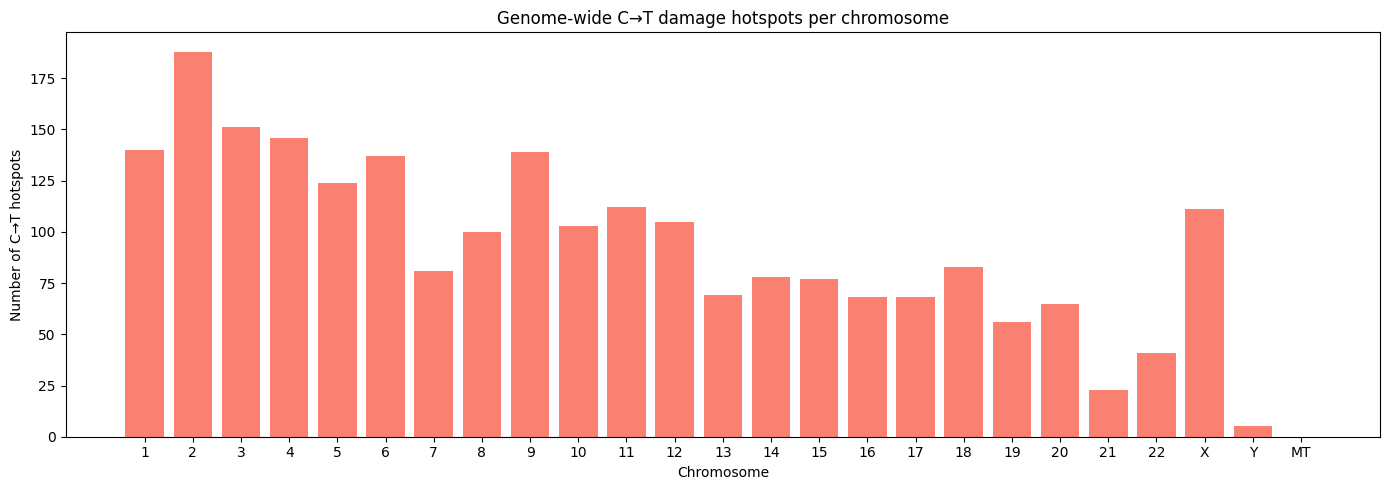

In [ ]:
# Canonical chromosome order
chrom_order = [str(i) for i in range(1, 23)] + ["X", "Y", "MT"]

# Ensure all chromosomes represented
hotspots_per_chr_plot = hotspots_per_chr.set_index("Chromosome").reindex(chrom_order, fill_value=0)

plt.figure(figsize=(14,5))
plt.bar(hotspots_per_chr_plot.index, hotspots_per_chr_plot["Hotspot_Count"], color='salmon')
plt.xlabel("Chromosome")
plt.ylabel("Number of C→T hotspots")
plt.title("Genome-wide C→T damage hotspots per chromosome")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


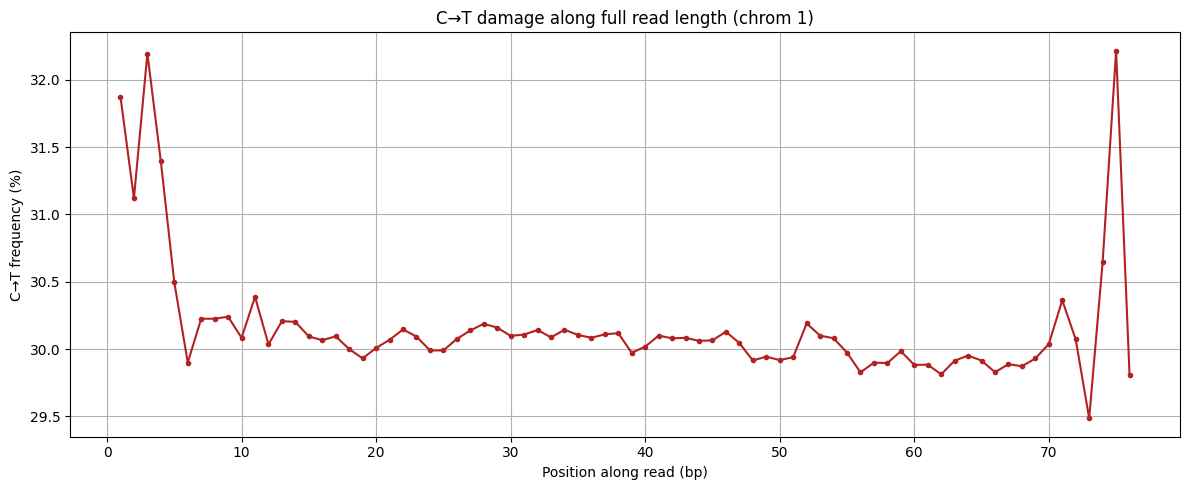

In [ ]:
# Dictionary: key = position, value = list of C->T (0/1) at that position
pos_counts = defaultdict(list)
chrom = "1"  # or whichever

all_reads_ct = []

with pysam.AlignmentFile(bam_file_path, "rb") as bam:
    for read in bam.fetch(chrom):
        if read.is_unmapped or read.query_sequence is None:
            continue
        seq = read.query_sequence
        for i, base in enumerate(seq):
            pos_counts[i].append(1 if base == "T" else 0)

# Compute mean per position without padding
max_pos = max(pos_counts.keys()) + 1
ct_rate_per_pos = np.zeros(max_pos)
for i in range(max_pos):
    if i in pos_counts:
        ct_rate_per_pos[i] = np.mean(pos_counts[i])
    else:
        ct_rate_per_pos[i] = np.nan  # optional


# rolling mean for noisy ends 
window = 5
ct_rate_smoothed = np.convolve(ct_rate_per_pos, np.ones(window)/window, mode='same')

plt.figure(figsize=(12,5))
plt.plot(range(1, len(ct_rate_per_pos)+1), ct_rate_per_pos*100, color='firebrick', marker='o', markersize=3)
plt.xlabel("Position along read (bp)")
plt.ylabel("C→T frequency (%)")
plt.title(f"C→T damage along full read length (chrom {chrom})")
plt.grid(True)
plt.tight_layout()
plt.show()

to do:

from main csv, append distance to nearest fragment end, run statistical analysis